In [39]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import json
import seaborn as sns
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from matplotlib import pyplot as plt
import torch
import os
import numpy as np
from sklearn.metrics import pairwise_distances
import time


In [17]:
PATH_METHYLATION = "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/Methylation"
FILE_PATH_DICT = "case_id_and_structure.json"
FILE_PATH_CONVERTER = "matched_cpg_genes.csv"
FILE_PATH_DATASTRUCTURE_CONVERTED = 'datastructure_converted.csv'

In [18]:
# Load the file path dictionary
with open(FILE_PATH_DICT, 'r') as file:
    file_parsed = json.load(file)

# Create dictionaries for case_id and os
file_to_case_id = {file_parsed[k]['files']['methylation']: k for k in file_parsed.keys()}
file_to_os = {file_parsed[k]['files']['methylation']: file_parsed[k]['os'] for k in file_parsed.keys()}

In [4]:
print(file_to_case_id)

{'c0c6191b-f9c0-4e33-8a20-1684230f5182.methylation_array.sesame.level3betas.txt': 'b3511675-fd68-4745-8020-e290ca0fd115', 'ae54509f-5df9-4bae-9d39-a03ca716968c.methylation_array.sesame.level3betas.txt': '4261267c-7042-4c6e-83ed-12fb401003fc', 'fb6f82c3-82bd-4af1-9f37-2cf868a84017.methylation_array.sesame.level3betas.txt': 'b7715ff6-57a6-4513-9447-aa8bc93f16d4', '5cf52e1d-a1df-4911-8496-6672232f43b0.methylation_array.sesame.level3betas.txt': '5d7027f5-60a0-47ab-a79d-667c9acc0e54', '9855b9f1-6c59-4fe1-ba86-8fd94a95f63c.methylation_array.sesame.level3betas.txt': '28ed2d42-5b4c-4bca-b2b2-6b2a6d3c42cf', '514cebe3-a634-4b78-9f46-09cd7e533de6.methylation_array.sesame.level3betas.txt': '7dcc809b-e33a-4453-b92a-c00786f48cb0', '4825da66-2f6b-4ba4-ad21-70a31bbf181e.methylation_array.sesame.level3betas.txt': '611600a6-43ec-4029-9682-cd6d6a3312ec', 'c55c3cf6-4566-4d65-a45d-3d4206c05de9.methylation_array.sesame.level3betas.txt': 'f8a5547f-f1bc-4c01-8b68-25b5ee0caeab', '2a2d315e-15a8-468d-b6d9-b306f9

In [19]:
# Initialize the DataFrame
datastructure = pd.DataFrame(columns=['case_id', 'os','methylation_id','methylation_values'])

index = 0
for root, dirs, files in os.walk(PATH_METHYLATION):
    for dir in dirs:
        for root, dirs, files in os.walk(os.path.join(PATH_METHYLATION, dir)):
            for file in files:
                if file in file_to_case_id.keys():
                    parsed_file = pd.read_csv(os.path.join(PATH_METHYLATION, dir, file),
                                              sep='\t', header=None, names=["id", "methylation"])
                    parsed_file = parsed_file[['id', 'methylation']]
                    parsed_file = parsed_file.astype({'methylation': float, 'id': str})

                    # Extract methylation values
                    methylation_id = parsed_file['id'].tolist()
                    methylation_values = parsed_file['methylation'].tolist()

                    # Add the data to the DataFrame
                    datastructure.loc[index] = [
                        file_to_case_id[file],
                        file_to_os[file],
                        methylation_id,
                        methylation_values
                    ]
                    index += 1


In [11]:
print(datastructure)

                                  case_id    os  \
0    dc5a6ce7-01e5-408d-812e-e3e0ddc1cde5   629   
1    5d1a54fe-e0df-4c17-b623-b649a136dc82  1688   
2    d2c0d320-d1c5-4eed-af4f-15540e60db0b  1189   
3    e641aed9-1dd8-4c30-b231-f12b20a76df0   788   
4    afd92922-b8dc-48bd-a9c0-bc8d95855eb7  1341   
..                                    ...   ...   
221  cf1e86ec-4bcb-403c-831b-d67bddef14eb   312   
222  28ed2d42-5b4c-4bca-b2b2-6b2a6d3c42cf    25   
223  65435f50-a35d-49e3-a36e-b95d9e274ca0  2688   
224  062982f8-9f49-425a-99e9-008af5ed9040   857   
225  08c64000-d320-4e4d-974b-da503d48890c  1767   

                                        methylation_id  \
0    [cg00000292, cg00002426, cg00003994, cg0000584...   
1    [cg00000292, cg00002426, cg00003994, cg0000584...   
2    [cg00000292, cg00002426, cg00003994, cg0000584...   
3    [cg00000292, cg00002426, cg00003994, cg0000584...   
4    [cg00000292, cg00002426, cg00003994, cg0000584...   
..                                     

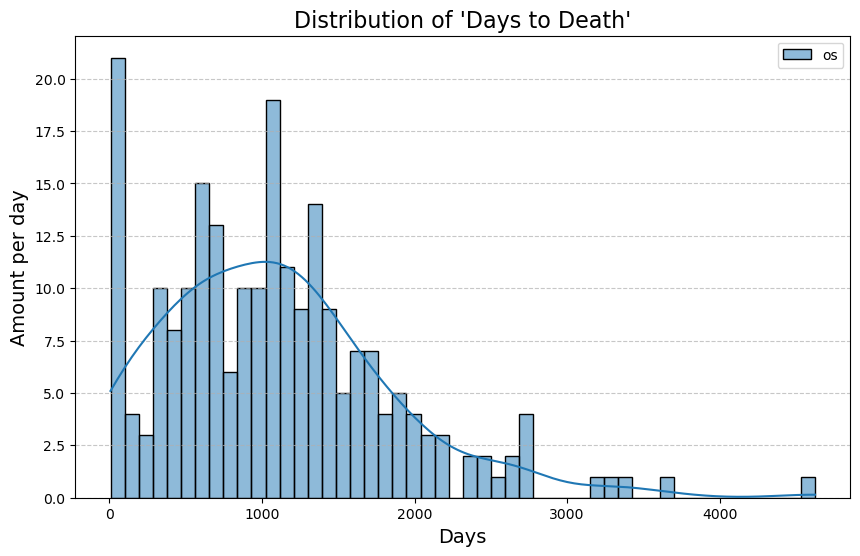

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(datastructure, bins=50, kde=True, color="red")
plt.title("Distribution of \'Days to Death\'", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Amount per day", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [20]:
# Carica il file di conversione
conversion_df = pd.read_csv(FILE_PATH_CONVERTER)

# Crea un dizionario per la conversione rapida
conversion_dict = pd.Series(conversion_df.gene_id.values, index=conversion_df.cpg_IlmnID).to_dict()

# Funzione per convertire methylation_id in gene_id utilizzando il dizionario
def convert_methylation_to_gene(methylation_ids, conversion_dict):
    return [conversion_dict.get(methylation_id, None) for methylation_id in methylation_ids]

# Crea una nuova colonna 'gene_id' nel DataFrame
datastructure['gene_id'] = datastructure['methylation_id'].apply(lambda x: convert_methylation_to_gene(x, conversion_dict))

print(datastructure)

/tmp/ipykernel_3033263/686524669.py:2: DtypeWarning: Columns (1,7) have mixed types. Specify dtype option on import or set low_memory=False.
  conversion_df = pd.read_csv(FILE_PATH_CONVERTER)


                                  case_id    os  \
0    dc5a6ce7-01e5-408d-812e-e3e0ddc1cde5   629   
1    5d1a54fe-e0df-4c17-b623-b649a136dc82  1688   
2    d2c0d320-d1c5-4eed-af4f-15540e60db0b  1189   
3    e641aed9-1dd8-4c30-b231-f12b20a76df0   788   
4    afd92922-b8dc-48bd-a9c0-bc8d95855eb7  1341   
..                                    ...   ...   
221  cf1e86ec-4bcb-403c-831b-d67bddef14eb   312   
222  28ed2d42-5b4c-4bca-b2b2-6b2a6d3c42cf    25   
223  65435f50-a35d-49e3-a36e-b95d9e274ca0  2688   
224  062982f8-9f49-425a-99e9-008af5ed9040   857   
225  08c64000-d320-4e4d-974b-da503d48890c  1767   

                                        methylation_id  \
0    [cg00000292, cg00002426, cg00003994, cg0000584...   
1    [cg00000292, cg00002426, cg00003994, cg0000584...   
2    [cg00000292, cg00002426, cg00003994, cg0000584...   
3    [cg00000292, cg00002426, cg00003994, cg0000584...   
4    [cg00000292, cg00002426, cg00003994, cg0000584...   
..                                     

In [21]:
# Calcolo della varianza per ogni lista in methylation_values
datastructure['methylation_variance'] = datastructure['methylation_values'].apply(lambda x: pd.Series(x).var())

# Trova le prime mille posizioni dei valori con la varianza più alta
max_variance_positions = datastructure['methylation_values'].apply(lambda x: pd.Series(x).nlargest(10000).index.tolist())

# Creazione di un nuovo DataFrame con solo i valori nelle posizioni elencate
df_variance = {
    'case_id': datastructure['case_id'],
    'os': datastructure['os'],
    'methylation_id': datastructure.apply(lambda row: [row['methylation_id'][i] for i in max_variance_positions[row.name]], axis=1),
    'methylation_values': datastructure.apply(lambda row: [row['methylation_values'][i] for i in max_variance_positions[row.name]], axis=1),
    'gene_id': datastructure.apply(lambda row: [row['gene_id'][i] for i in max_variance_positions[row.name]], axis=1)
}

df_variance = pd.DataFrame(df_variance)

print("Nuovo DataFrame con solo i valori nelle posizioni elencate:")
print(df_variance)
#print(df_variance.info())

Nuovo DataFrame con solo i valori nelle posizioni elencate:
                                  case_id    os  \
0    dc5a6ce7-01e5-408d-812e-e3e0ddc1cde5   629   
1    5d1a54fe-e0df-4c17-b623-b649a136dc82  1688   
2    d2c0d320-d1c5-4eed-af4f-15540e60db0b  1189   
3    e641aed9-1dd8-4c30-b231-f12b20a76df0   788   
4    afd92922-b8dc-48bd-a9c0-bc8d95855eb7  1341   
..                                    ...   ...   
221  cf1e86ec-4bcb-403c-831b-d67bddef14eb   312   
222  28ed2d42-5b4c-4bca-b2b2-6b2a6d3c42cf    25   
223  65435f50-a35d-49e3-a36e-b95d9e274ca0  2688   
224  062982f8-9f49-425a-99e9-008af5ed9040   857   
225  08c64000-d320-4e4d-974b-da503d48890c  1767   

                                        methylation_id  \
0    [cg21430666, cg27182551, cg02723533, cg2340175...   
1    [cg02723533, cg21430666, cg20483763, cg2127059...   
2    [cg02723533, cg25004981, cg21270593, cg2048376...   
3    [cg25178645, cg09748975, cg01347719, cg2127059...   
4    [cg20483763, cg02723533, cg23401

In [22]:
# Funzione per rimuovere i valori None dalle liste e le posizioni corrispondenti in altre colonne
def remove_none_and_corresponding_positions(df):
    # Trova le posizioni dei valori None in gene_id
    none_positions = df['gene_id'].apply(lambda x: [i for i, value in enumerate(x) if value is None])

    # Rimuovi i valori None da gene_id e le posizioni corrispondenti da methylation_id e methylation_values
    df['gene_id'] = df['gene_id'].apply(lambda x: [value for value in x if value is not None])
    df['methylation_id'] = df.apply(lambda row: [value for i, value in enumerate(row['methylation_id']) if i not in none_positions[row.name]], axis=1)
    df['methylation_values'] = df.apply(lambda row: [value for i, value in enumerate(row['methylation_values']) if i not in none_positions[row.name]], axis=1)

    return df

# Applica la funzione al DataFrame
df_variance = remove_none_and_corresponding_positions(df_variance)

# Rimuovi le righe dove la lista gene_id è vuota dopo aver rimosso i valori None
df_variance = df_variance[df_variance['gene_id'].map(len) > 0]

print(df_variance)

                                  case_id    os  \
0    dc5a6ce7-01e5-408d-812e-e3e0ddc1cde5   629   
1    5d1a54fe-e0df-4c17-b623-b649a136dc82  1688   
2    d2c0d320-d1c5-4eed-af4f-15540e60db0b  1189   
3    e641aed9-1dd8-4c30-b231-f12b20a76df0   788   
4    afd92922-b8dc-48bd-a9c0-bc8d95855eb7  1341   
..                                    ...   ...   
221  cf1e86ec-4bcb-403c-831b-d67bddef14eb   312   
222  28ed2d42-5b4c-4bca-b2b2-6b2a6d3c42cf    25   
223  65435f50-a35d-49e3-a36e-b95d9e274ca0  2688   
224  062982f8-9f49-425a-99e9-008af5ed9040   857   
225  08c64000-d320-4e4d-974b-da503d48890c  1767   

                                        methylation_id  \
0    [cg21430666, cg15142488, cg17188169, cg1750032...   
1    [cg21430666, cg15142488, cg00062776, cg1096728...   
2    [cg04382920, cg21430666, cg24845207, cg1093506...   
3    [cg15142488, cg17500329, cg02899723, cg1093506...   
4    [cg21430666, cg15142488, cg04382920, cg2626756...   
..                                     

In [23]:
# Creazione di un nuovo DataFrame con i 1000 valori con varianza più alta da df_variance
top_1000_data = {
    'case_id': df_variance['case_id'],
    'os': df_variance['os'],
    'methylation_id': df_variance['methylation_id'].apply(lambda x: x[:1000]),
    'methylation_values': df_variance['methylation_values'].apply(lambda x: x[:1000]),
    'gene_id': df_variance['gene_id'].apply(lambda x: x[:1000])
}

df = pd.DataFrame(top_1000_data)

In [24]:
df.to_csv(FILE_PATH_DATASTRUCTURE_CONVERTED, index=False)

Media della metilazione: 0.7752549734827315
Mediana della metilazione: 0.827277003571371


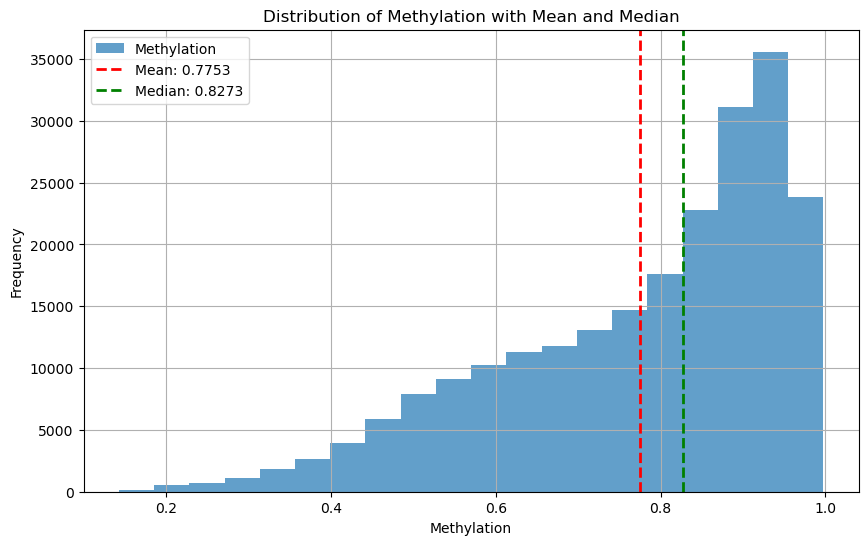

In [32]:
# Creiamo una lista per contenere tutti i valori di metilazione
all_methylation_values = []

# Itera attraverso il DataFrame e aggiungi i valori di metilazione alla lista
for index, row in df.iterrows():
    methylation_values = row['methylation_values']
    all_methylation_values.extend(methylation_values)

# Calcola la media e la mediana
mean_methylation = pd.Series(all_methylation_values).mean()
median_methylation = pd.Series(all_methylation_values).median()

print("Media della metilazione:", mean_methylation)
print("Mediana della metilazione:", median_methylation)

# Rappresenta la media e la mediana in un grafico
plt.figure(figsize=(10, 6))
plt.hist(all_methylation_values, bins=20, alpha=0.7, label='Methylation')
plt.axvline(mean_methylation, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_methylation:.4f}')
plt.axvline(median_methylation, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_methylation:.4f}')
plt.xlabel('Methylation')
plt.ylabel('Frequency')
plt.title('Distribution of Methylation with Mean and Median')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
THRESHOLD = median_methylation

list_of_Data_without_NaN = []
methylation_data = df['methylation_values'].values
feature_size = methylation_data.shape[0]
edges = [[], []]

# Calcola la matrice delle distanze
dist_matrix = np.zeros((feature_size, feature_size))
for i in range(feature_size):
    for j in range(i + 1, feature_size):
        dist_matrix[i, j] = np.linalg.norm(np.array(methylation_data[i]) - np.array(methylation_data[j]))

# Trova gli indici dove la similarità è inferiore o uguale alla soglia
f_1_indices, f_2_indices = np.where(dist_matrix <= THRESHOLD)
for f_1_index, f_2_index in zip(f_1_indices, f_2_indices):
    if f_1_index < f_2_index:  # Assicurati di non duplicare gli indici
        edges[0].append(f_1_index)
        edges[0].append(f_2_index)
        edges[1].append(f_2_index)
        edges[1].append(f_1_index)

edge_index = torch.tensor(edges, dtype=torch.long)
x = torch.tensor(methylation_data, dtype=torch.float)

list_of_Data_without_NaN.append(Data(x=x, edge_index=edge_index))

ValueError: setting an array element with a sequence.